# Setup

In [26]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
import os
import shutil
from collections import Counter

Pour accéder aux données, vous pouvez soit passer par le drive en y téléchargeant les données sur le git, soit en important directement les images sur Colab.

In [73]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Utils

In [62]:
# Generation of train, valid and test folders for the datasets
def generate_train_valid_test(val_ratio, test_ratio, src_path, dest_path=None):

    # If no dest path, initializing it to same as src_path
    if not dest_path:
        dest_path = src_path

    folders = ["train", "valid", "test"]
    classes = ["Amanita bisporigera", "Amanita muscaria", "Boletus edulis", "Cantharellus", "Omphalotus olearius", "Russula mariae"]
    
    # Create all folder architecture if it's not existing already
    for folder in folders:
        path = os.path.join(dest_path, folder)
        if not os.path.exists(path):
            os.makedirs(path)
        for classe in classes:
            class_path = os.path.join(path, classe)
            os.makedirs(class_path)
            
    # Copy of files in each dataset folders based on ratios
    for classe in classes:
        class_src_path = os.path.join(src_path, classe)
        
        files = os.listdir(class_src_path)
        n = len(files)
        for i, img in enumerate(files):
            if i < n * val_ratio:
                shutil.copyfile(os.path.join(class_src_path, img), os.path.join(dest_path, "valid", classe, img))
            elif i < n * (val_ratio + test_ratio):
                shutil.copyfile(os.path.join(class_src_path, img), os.path.join(dest_path, "test", classe, img))
            else:
                shutil.copyfile(os.path.join(class_src_path, img), os.path.join(dest_path, "train", classe, img))

In [63]:
# Resize and convert an image to an array
# 2 resize modes : fill_black, fill_pixel (default)
def resize_image(img, resize_mode="fill_pixel", size=256):
    
    # Get width or height based on initial aspect ratio for the new max size
    if img.height > img.width:
        h = size
        w = int(size * img.width / img.height)
    else:
        h = int(size * img.height / img.width)
        w = size
    
    resized_img = img.resize((w, h))
    
    # Convert to array and add columns or rows based on resize_mode to get a square matrix
    img_array = keras.preprocessing.image.img_to_array(resized_img, dtype="uint8")
    
    if h == w:
        return img_array
    elif h > w:
        axis = 1
        zero_matrix = np.zeros((h, h - w, 3), dtype=np.int8)
        if resize_mode != "fill_black":
          last_col = img_array[:, -1, :]
          last_col = np.expand_dims(last_col, axis=1)
          zero_matrix = last_col + zero_matrix
    else:
        axis = 0
        zero_matrix = np.zeros((w - h, w, 3), dtype=np.int8)
        if resize_mode != "fill_black":
          zero_matrix = zero_matrix + img_array[-1]
        
    return np.concatenate((img_array, zero_matrix), axis=axis)

In [64]:
# Resize image from dataset
def resize_dataset_image(src_path, dest_path, resize_mode="fill_pixel", size=256):

    folders = ["train", "valid", "test"]
    classes = ["Amanita bisporigera", "Amanita muscaria", "Boletus edulis", "Cantharellus", "Omphalotus olearius", "Russula mariae"]

    # Create destination folders if they doesn't already exist
    if not os.path.exists(dest_path):
        os.makedirs(dest_path)

    # For each folder and each class, resize all images and save them to dest folder
    for folder in folders:
        for classe in classes:
            path = os.path.join(src_path, folder, classe)
            files = os.listdir(path)
            for imageFile in files:
                image = keras.preprocessing.image.load_img(os.path.join(path, imageFile))
                resized_image = resize_image(image, resize_mode, size)
        
                save_path = os.path.join(dest_path, folder, classe)
                if not os.path.exists(save_path):
                    os.makedirs(save_path)

                keras.preprocessing.image.save_img(os.path.join(save_path, imageFile), resized_image)

In [65]:
# Load train, valid and test datasets
def load_datasets(directory, image_size, batch_size):

    datasets = []
    folders = ["train", "valid", "test"]

    for folder in folders:
        print(f"Loading {folder} dataset...")
        dataset = keras.preprocessing.image_dataset_from_directory(
            os.path.join(directory, folder),
            image_size=(image_size, image_size),
            batch_size=batch_size)
        datasets.append(dataset)

    return tuple(datasets)

In [66]:
# Preview 9 images of a dataset
def preview_dataset(dataset):

    # Retrieve 9 images and labels from a batch of the dataset
    batch = next(iter(dataset.take(1)))
    batch_images = batch[0][:9]
    batch_labels = batch[1][:9]

    subset = zip(batch_images, batch_labels)

    # Display with pyplot
    plt.figure(figsize=(8, 8))
    for i, (image, label) in enumerate(subset, 1):
        plt.subplot(3, 3, i)
        plt.axis("off")
        plt.imshow(image.numpy().astype("uint8"))
        plt.title(dataset.class_names[label.numpy().astype("uint8")])

In [67]:
# Get plots for stats after fit
def plot_stats(history, stats_to_plot, start=0, epochs=None):

    # If epochs not provided, take all epochs until the end of history
    lines = len(stats_to_plot)
    if not epochs:
        epochs = len(history.history[stats_to_plot[0]])

    # Plot each stat with train and valid datasets values
    plt.figure(figsize=(8, lines * 4))
    for i, stat in enumerate(stats_to_plot, 1):
        plt.subplot(lines, 1, i)
        plt.plot(range(start, epochs), history.history[stat][start:epochs])
        plt.plot(range(start, epochs), history.history[f"val_{stat}"][start:epochs])
        plt.title(stat.capitalize())

In [68]:
# Visualization of the class distribution 
def dataset_distribution(train_ds, val_ds, test_ds):
  datasets = (train_ds, val_ds, test_ds)

  plot_labels = ["train", "validation", "test"]
  data_labels = ["Amanita bisporigera", "Amanita muscaria", "Boletus edulis", "Cantharellus", "Omphalotus olearius", "Russula mariae"]
  data_labels_count = [[] for i in range(len(data_labels))]

  x = np.arange(len(plot_labels))
  width = 0.1

  # Get how many images for each class in each subset
  for dataset in datasets:
    dataset = dataset.unbatch()
    dataset = list(dataset.as_numpy_iterator())
    outputs = [y for x, y in dataset]
    count = Counter(outputs)

    for i in range(len(data_labels)):
      data_labels_count[i].append(count[i])

  # Creation of the bar plot
  fig, ax = plt.subplots()
  for i, data_label in enumerate(data_labels):
    ax.bar(x + i*width - 5*width/2, data_labels_count[i], width, label=data_label)

  ax.set_ylabel('Nbr of images')
  ax.set_title('Distribution of each class in each subset')
  ax.set_xticks(x)
  ax.set_xticklabels(plot_labels)
  ax.legend()
  fig.set_size_inches(15, 8)

# Variables à définir

In [69]:
root_folder = "./drive/MyDrive/Projet IA Hexagone"
original_dataset_source_path = os.path.join(root_folder, "All_Mushroom_Data")

# Préparation des données

## Preprocessing des données

Une fois notre dataset trouvé et téléchargé, nous nous sommes retrouvés avec une architecture de dossier comme suit :
```
main_directory/
...class_a/
......00001.jpg
......00002.jpg
...class_b/
......00134.jpg
......00135.jpg
```
Il nous était donc possible d'obtenir simplement un dataset de training ainsi que de validation via l'API Keras. Cependant, nous ne pouvons pas obtenir de dataset de test.

Nous avons donc décidé de processer nos données afin de les séparer en 3 dossiers (train, valid et test) selon un certain ratio afin de pouvoir facilement les charger plus tard.

La fonction `generate_train_valid_test` que nous avons faite a donc permis de créer ces 3 dossiers:


In [70]:
generate_train_valid_test(val_ratio=0.1, test_ratio=0.1, src_path=original_dataset_source_path)

Une fois nos dossiers obtenus, nous avons pu charger nos datasets. Cepedant, toutes les images n'ont pas la même taille, ni le même ratio hauteur/largeur. Les images sont donc étirées au chargement afin d'obtenir une taille que l'on a définie (256x256).

Au fil du dévelopement de notre modèle, nous avons voulu tester nos images sans les étirer afin de voir si cela avait une influence.

Nous avons donc créé la fonction `resize_image` qui permet de compléter une image, soit avec du noir, soit avec des pixels de l'image afin d'atteindre la taille voulue sans étirement:

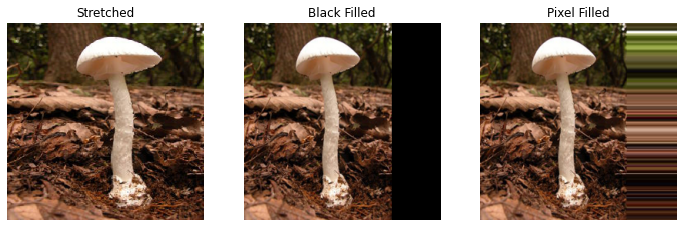

In [76]:
src_image = keras.preprocessing.image.load_img(os.path.join(original_dataset_source_path, "train", "Amanita bisporigera", "674.jpg"))

image_stretched = keras.preprocessing.image.load_img(os.path.join(original_dataset_source_path, "train", "Amanita bisporigera", "674.jpg"), target_size=(256, 256))
image_black_filled = resize_image(src_image, resize_mode='fill_black', size=256)
image_pixel_filled = resize_image(src_image, resize_mode='fill_pixel', size=256)

plt.figure(figsize=(12, 5))

plt.subplot(1, 3, 1)
plt.axis("off")
plt.imshow(image_stretched)
plt.title("Stretched")

plt.subplot(1, 3, 2)
plt.axis("off")
plt.imshow(image_black_filled)
plt.title("Black Filled")

plt.subplot(1, 3, 3)
plt.axis("off")
plt.imshow(image_pixel_filled)
plt.title("Pixel Filled")

plt.show()

Nous avons donc développpée la fonction `resize_dataset_image` autour de la fonction précédente afin de générer un nouveau dataset en enregistrant les images processées (le dossier source doit déjà être sous la forme train/valid/test):



In [71]:
# Création du dossier contenant les images complétées par du noir
fill_black_dataset_source_path = os.path.join(root_folder, "All_Mushroom_Data_Fill_Black")
resize_dataset_image(src_path=original_dataset_source_path, dest_path=fill_black_dataset_source_path, resize_mode="fill_black", size=256)

In [75]:
# Création du dossier contenant les images complétées ses propres pixels
fill_pixel_dataset_source_path = os.path.join(root_folder, "All_Mushroom_Data_Fill_Pixel")
resize_dataset_image(src_path=original_dataset_source_path, dest_path=fill_pixel_dataset_source_path, resize_mode="fill_pixel", size=256)

## Récupération des datasets

Définition de quelques variables pour le chargement des données ainsi que le chemin du dataset à utiliser (original, fill_black ou fill_pixel) 

In [79]:
batch_size = 32
image_size = 256
data_dir = os.path.join(root_folder, "All_Mushroom_Data_Fill_Pixel") # <= A remplacer selon l'emplacement du dataset à charger

Chargement des datasets d'entrainement, de validation et de test

In [80]:
train_ds, val_ds, test_ds = load_datasets(data_dir, image_size, batch_size)

Loading train dataset...
Found 2574 files belonging to 6 classes.
Loading valid dataset...
Found 324 files belonging to 6 classes.
Loading test dataset...
Found 322 files belonging to 6 classes.


Visualisation des différentes classes

In [81]:
train_ds.class_names

['Amanita bisporigera',
 'Amanita muscaria',
 'Boletus edulis',
 'Cantharellus',
 'Omphalotus olearius',
 'Russula mariae']

Visualisation de la distribution des classes sur chacun des sous-ensembles

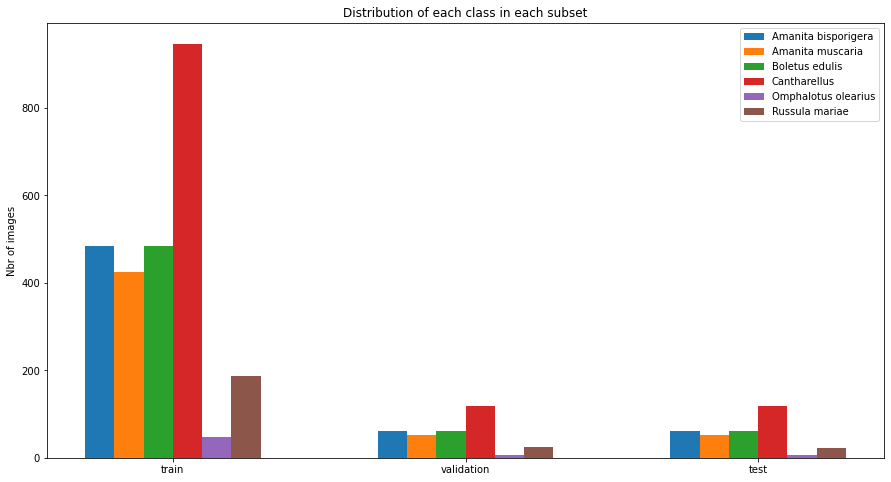

In [82]:
dataset_distribution(train_ds, val_ds, test_ds)

Aperçu de quelques images du dataset d'entrainement

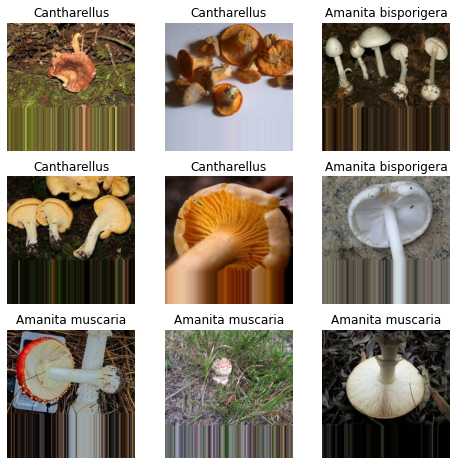

In [83]:
preview_dataset(train_ds)

# Création et entrainement du modèle

## Architecture du modèle

In [85]:
keras.backend.clear_session()

### Création de l'architecture


In [86]:
model = keras.Sequential([
    keras.Sequential([
      keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
      keras.layers.experimental.preprocessing.RandomFlip("vertical"),
      keras.layers.experimental.preprocessing.RandomRotation(0.1),
      keras.layers.experimental.preprocessing.RandomZoom(0.1),
    ]),
    keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(image_size, image_size, 3)),
    keras.layers.Conv2D(8, 5, padding='valid', activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Conv2D(16, 5, padding='valid', activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Conv2D(16, 5, padding='valid', activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.1),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(6, activation='softmax')
])

In [87]:
optimizer = keras.optimizers.Adam(learning_rate=0.001) # 0.01 | 0.001 (Best) | 0.0005 (Good) | 0.0001 | 0.00001
loss = keras.losses.SparseCategoricalCrossentropy()
metrics = ['accuracy']

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

### Quelques détails sur le modèle

Visualisation de l'architecture et du nombre de paramètres

In [88]:
model.build(input_shape=(1, image_size, image_size, 3))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (1, 256, 256, 3)          0         
_________________________________________________________________
rescaling (Rescaling)        (1, 256, 256, 3)          0         
_________________________________________________________________
conv2d (Conv2D)              (1, 252, 252, 8)          608       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (1, 126, 126, 8)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (1, 122, 122, 16)         3216      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (1, 61, 61, 16)           0         
_________________________________________________________________
conv2d_2 (Conv2D)            (1, 57, 57, 16)          

Test du modèle non entrainé sur l'ensemble de test

In [92]:
model.evaluate(test_ds)

11/11 [==============================] - 1s 30ms/step - loss: 1.7698 - accuracy: 0.2081


[1.7698019742965698, 0.20807453989982605]

## Entrainement

Définition d'un scheduler permettant de baisser le learning rate dynamiquement pendant le fit afin d'optimiser le temps d'entrainement tout en ayant un learning rate final assez bas

In [38]:
def scheduler(epoch, lr):
  if epoch == 70:
    lr = lr/2
    
  if epoch < 80:
    return lr

  return lr * tf.math.exp(-0.1)

lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

Entrainement avec un nombre d'epochs défini

In [49]:
epochs = 150

history = model.fit(
  train_ds,
  epochs=epochs,
  validation_data=val_ds,
  callbacks=[lr_callback]
)

Epoch 1/150
83/83 [==============================] - 9s 93ms/step - loss: 1.8656 - accuracy: 0.2836 - val_loss: 1.5352 - val_accuracy: 0.4486
Epoch 2/150
83/83 [==============================] - 8s 91ms/step - loss: 1.3233 - accuracy: 0.5123 - val_loss: 1.2336 - val_accuracy: 0.5479
Epoch 3/150
83/83 [==============================] - 8s 90ms/step - loss: 1.1662 - accuracy: 0.5701 - val_loss: 1.1243 - val_accuracy: 0.5925
Epoch 4/150
83/83 [==============================] - 8s 90ms/step - loss: 1.0504 - accuracy: 0.6147 - val_loss: 1.1162 - val_accuracy: 0.5719
Epoch 5/150
83/83 [==============================] - 8s 90ms/step - loss: 1.0211 - accuracy: 0.6371 - val_loss: 1.2769 - val_accuracy: 0.4589
Epoch 6/150
83/83 [==============================] - 8s 90ms/step - loss: 0.9764 - accuracy: 0.6433 - val_loss: 1.5376 - val_accuracy: 0.4349
Epoch 7/150
83/83 [==============================] - 8s 90ms/step - loss: 0.9970 - accuracy: 0.6406 - val_loss: 1.1778 - val_accuracy: 0.5890
Epoch 

## Visualisation et analyse des resulats

Visualisation des metriques enregistrées pendant le fit (possibilité de visualiser qu'à partir d'un certain epoch)

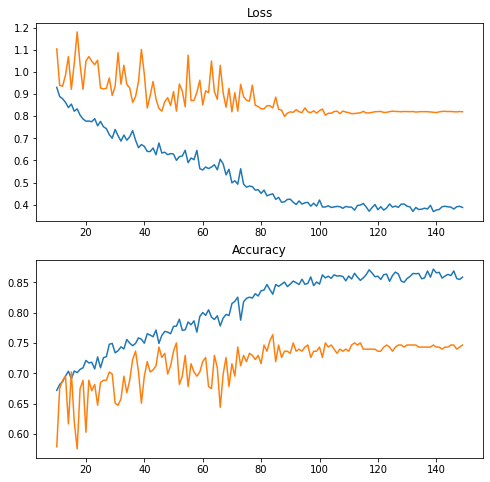

In [50]:
plot_stats(history, ['loss', *metrics], start=10)

Evaluation des résulats obtenus avec le modèle sur le jeu de test

In [51]:
model.evaluate(test_ds)

10/10 [==============================] - 1s 16ms/step - loss: 1.1038 - accuracy: 0.6990


[1.1038185358047485, 0.6989619135856628]

## Enregistrement du modèle

Enregistrement du modèle s'il est convenable

In [ ]:
model_path = os.path.join(root_folder, "ModelSaves", '008')

tf.saved_model.save(model, model_path)

INFO:tensorflow:Assets written to: ./drive/MyDrive/Projet IA Hexagone/ModelSaves/007/assets


# Modele pré-entrainé

In [52]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [53]:
train_data_generator = keras.preprocessing.image.ImageDataGenerator(rescale=1./255, 
                                                                    rotation_range=20,
                                                                    horizontal_flip=True)

train_generator = train_data_generator.flow_from_directory(os.path.join(root_folder, "All_Mushroom_Data_Fill_Pixel", "train"),
                                             batch_size=32,
                                             class_mode="sparse",
                                             target_size=(256, 256))

val_data_generator = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

val_generator = val_data_generator.flow_from_directory(os.path.join(root_folder, "All_Mushroom_Data_Fill_Pixel", "valid"),
                                             batch_size=32,
                                             class_mode="sparse",
                                             target_size=(256, 256))

test_data_generator = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

test_generator = test_data_generator.flow_from_directory(os.path.join(root_folder, "All_Mushroom_Data_Fill_Pixel", "test"),
                                             batch_size=32,
                                             class_mode="sparse",
                                             target_size=(256, 256))

Found 2636 images belonging to 6 classes.
Found 292 images belonging to 6 classes.
Found 289 images belonging to 6 classes.


In [58]:
base_pretrained_model = InceptionV3(input_shape=(image_size, image_size, 3), weights='imagenet', include_top=False)

for layer in base_pretrained_model.layers:
    layer.trainable = False

x = keras.layers.Flatten()(base_pretrained_model.output)
x = keras.layers.Dense(1024, activation='relu')(x)
x = keras.layers.Dropout(0.1)(x)
x = keras.layers.Dense(6, activation='softmax')(x)

pretrained_model = keras.models.Model(base_pretrained_model.input, x)

pretrained_model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [59]:
epochs = 10

inception_history = pretrained_model.fit(
  train_generator,
  epochs=epochs,
  validation_data=val_generator
)

Epoch 1/10
83/83 [==============================] - 44s 486ms/step - loss: 9.2598 - accuracy: 0.4915 - val_loss: 1.1792 - val_accuracy: 0.7089
Epoch 2/10
83/83 [==============================] - 39s 467ms/step - loss: 1.1005 - accuracy: 0.7377 - val_loss: 0.8495 - val_accuracy: 0.7671
Epoch 3/10
83/83 [==============================] - 39s 468ms/step - loss: 0.6487 - accuracy: 0.8138 - val_loss: 0.7984 - val_accuracy: 0.7945
Epoch 4/10
83/83 [==============================] - 39s 465ms/step - loss: 0.6325 - accuracy: 0.8219 - val_loss: 0.7372 - val_accuracy: 0.8082
Epoch 5/10
83/83 [==============================] - 39s 467ms/step - loss: 0.4398 - accuracy: 0.8525 - val_loss: 1.1140 - val_accuracy: 0.7295
Epoch 6/10
83/83 [==============================] - 39s 465ms/step - loss: 0.4648 - accuracy: 0.8533 - val_loss: 0.8738 - val_accuracy: 0.7774
Epoch 7/10
83/83 [==============================] - 39s 470ms/step - loss: 0.3622 - accuracy: 0.8868 - val_loss: 0.9997 - val_accuracy: 0.7021

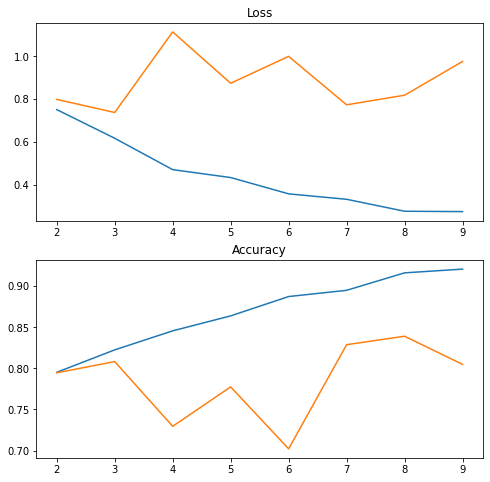

In [60]:
plot_stats(inception_history, ['loss', 'accuracy'], start=2)

In [61]:
pretrained_model.evaluate(test_generator)

10/10 [==============================] - 1s 94ms/step - loss: 1.3624 - accuracy: 0.7509


[1.3624340295791626, 0.7508650422096252]